In [50]:
# Images are from here http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# From those, I selected 10 categories of dogs
import os, shutil, random

parent_f = "/home/gpachitariu/git/ml-practice/CNN/dogs"
image_f = parent_f + '/Images_120classes' # '/Images'
train_f = parent_f + '/train'
test_f = parent_f + '/test'

def recreate_folder(f):
    if os.path.exists(f): 
        shutil.rmtree(f)
    os.mkdir(f)

def create_reset_train_test_set():
    recreate_folder(train_f)
    recreate_folder(test_f)

    for label_f in os.listdir(image_f):
        if random.random() > 0.1:
            continue
        os.mkdir(train_f + '/' + label_f)
        os.mkdir(test_f + '/' + label_f)

        for img in os.listdir(image_f + '/' + label_f):          
            dest_folder = test_f if random.random() < 0.2 else train_f

            shutil.copyfile(image_f + '/' + label_f + '/' + img, 
                           dest_folder + '/' + label_f + '/' + img)

# Only run this when you want to reset the train/test set
create_reset_train_test_set()

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.data.experimental import AUTOTUNE

import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

tf.enable_eager_execution()

### Getting the images and labels

In [52]:
CLASS_NAMES = np.array(os.listdir(train_f))
print(CLASS_NAMES[:3])
print(len(CLASS_NAMES))

['n02106662-German_shepherd' 'n02096177-cairn' 'n02109961-Eskimo_dog']
22


In [53]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.compat.v2.strings.split(file_path, '/')
    # The second to last is the class-directory
    return tf.math.equal(parts[-2], CLASS_NAMES)

ORIGINAL_SIZE = 448
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, (ORIGINAL_SIZE, ORIGINAL_SIZE))

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [54]:
list_train_ds = tf.data.Dataset.list_files(str(train_f + '/*/*'))
labeled_train_ds = list_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

list_test_ds = tf.data.Dataset.list_files(str(test_f + '/*/*'))
labeled_test_ds = list_test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### Procesing the images

In [55]:
def augment(img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:    
    # These 4 are added by me as a helper to get to 70% accuracy, not part of the paper
    #TODO img = tf.keras.preprocessing.image.random_rotation(rg=45, fill_mode='constant', cval=0)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    crop_size = (tf.random.uniform([1])[0] * 0.25 + 0.75) * ORIGINAL_SIZE 
    img = tf.image.random_crop(img, size = (crop_size, crop_size, 3)) # zoom in & out. max(zoom_out)=original size
    img = tf.image.resize(img, size = tf.constant((224, 224)))
    
    img = tf.image.random_flip_left_right(img)    
    return img, label

def normalize(img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
    # the values are between 0 and 1. We make them between -0.5 and 0.5
    return img - 0.5, label

In [56]:
train_image_count = tf.data.experimental.cardinality(list_train_ds).numpy()
BATCH_SIZE = 128
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()  # Repeat forever
    
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE)

    # dataset fetches batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [57]:
def resize_test(img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
    # TODO rewrite this like in paper
    return tf.image.resize(img, (224, 224)), label

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
    ds = ds.cache()
    
    ds = ds.map(resize_test, num_parallel_calls=AUTOTUNE)
    ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [58]:
train_ds = prepare_for_training(labeled_train_ds)
test_ds = prepare_for_testing(labeled_test_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

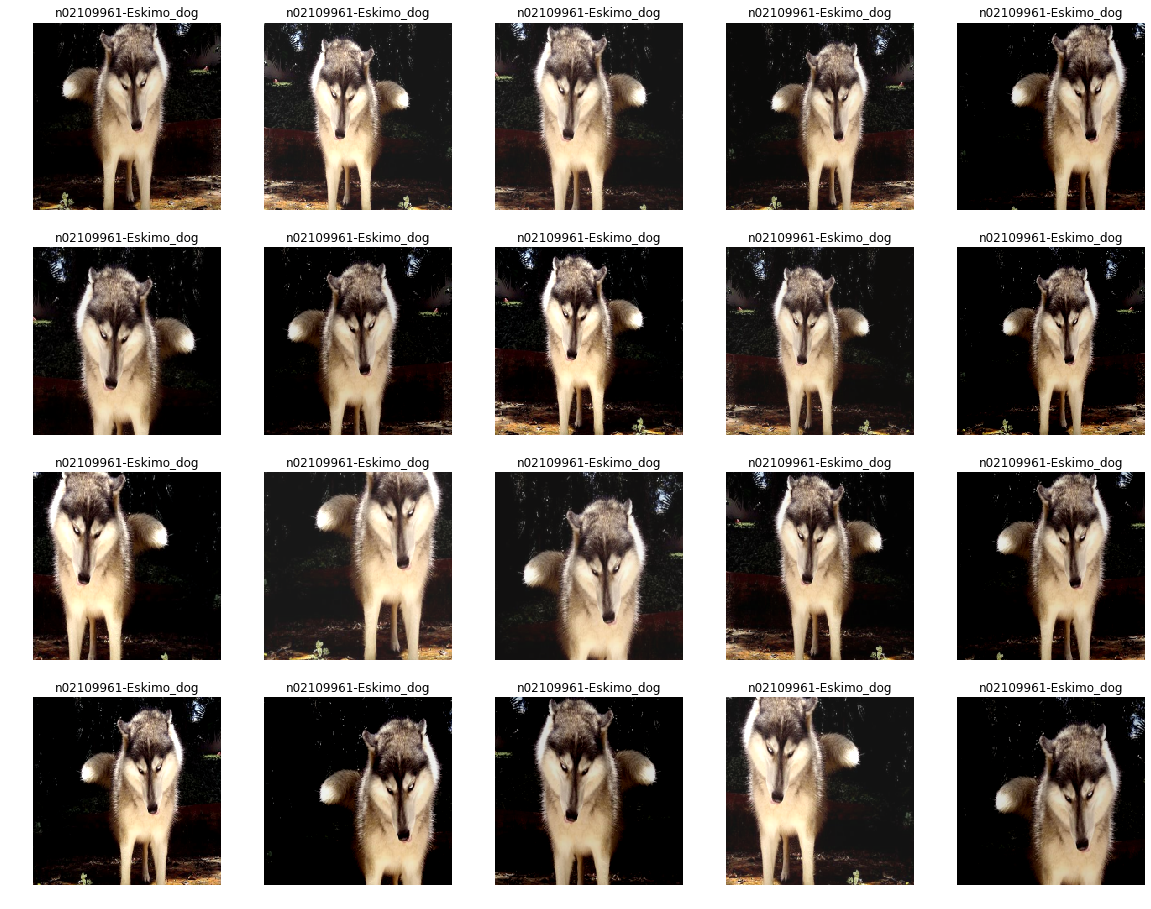

In [63]:
def show_batch(image_batch, label_batch):
    nr_images = 20
    images = []
    with tf.Session().as_default():
        images = image_batch[:nr_images].numpy().astype(float)
    
    plt.figure(figsize=(20,20))
    for n in range(nr_images):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(images[n] + 0.5)
        #plt.title(label_batch[n])
        plt.title(CLASS_NAMES[np.nonzero(label_batch[n].numpy())[0]][0])
        plt.axis('off')

def preview_augmentation():
    # we take only 1 to see how the augmentation worked
    preview_labeled_train_ds = labeled_train_ds.take(1)
    preview_train_ds = prepare_for_training(preview_labeled_train_ds)

    image_batch, label_batch = next(iter(preview_train_ds))
    show_batch(image_batch, label_batch)

preview_augmentation()

### Preprocessing the images

In [25]:
# TODO At test time, the network makes a prediction by extracting five 224 × 224 patches 
# (the four corner patches and the center patch) as well as their horizontal reflections (hence ten patches in all),
# and averaging the predictions made by the network’s softmax layer on the ten patches

def normalized_init(number_inputs):
    return tf.compat.v1.keras.initializers.RandomNormal(mean=0.0, stddev=1/number_inputs) 

k_init=tf.compat.v1.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
point_one=tf.compat.v2.constant_initializer(value=0.01)

model = keras.Sequential([
    keras.layers.Conv2D(96, (11, 11), input_shape=(224, 224, 3),  strides=4, activation='relu', 
                        bias_initializer='zeros', kernel_initializer=normalized_init(121)),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    
    keras.layers.Conv2D(256, (5, 5), activation='relu', bias_initializer=point_one, 
                        kernel_initializer=normalized_init(25)),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    
    keras.layers.Conv2D(384, (3, 3), activation='relu', bias_initializer='zeros', 
                        kernel_initializer=normalized_init(9)),

    # 4th conv. layer
    keras.layers.Conv2D(384, (3, 3), activation='relu', bias_initializer=point_one, 
                        kernel_initializer=normalized_init(9)),

    # TODO: How does the Convolutional layer work?
    # 1. For every convolution from every filter, it connects with a (3,3) window to all 384 previous filters?
    # 2. Should it be 9 ? or 9*384?
    keras.layers.Conv2D(256, (3, 3), activation='relu', bias_initializer=point_one, 
                        kernel_initializer=normalized_init(9)),
    
    keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),        
    keras.layers.Dense(4096, activation='relu', bias_initializer=point_one, 
                       # TODO why is smaller number better 216 vs 4096
                       kernel_initializer=normalized_init(216)),
    
    tf.keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(4096, activation='relu', bias_initializer=point_one, 
                       kernel_initializer=normalized_init(100)),
    
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax', bias_initializer='zeros', 
                       kernel_initializer=normalized_init(100)) # 4096
])

#learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001, decay_steps=1200,
#                                                                 end_learning_rate=0.0005*0.001, power=1)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), # learning_rate=learning_rate_fn
              loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)        

In [27]:
history = model.fit_generator(generator=train_ds,
                    steps_per_epoch = STEPS_PER_EPOCH,                    
                    validation_data = test_ds, 
                    epochs=60)

Epoch 1/60
19/19 [==============================] - 78s 4s/step - loss: 6.6497 - acc: 0.0592 - top_k_categorical_accuracy: 0.1702 - val_loss: 2.8396 - val_acc: 0.0765 - val_top_k_categorical_accuracy: 0.1965
Epoch 2/60
19/19 [==============================] - 70s 4s/step - loss: 2.8476 - acc: 0.0728 - top_k_categorical_accuracy: 0.1933 - val_loss: 2.8248 - val_acc: 0.0835 - val_top_k_categorical_accuracy: 0.2452
Epoch 3/60
19/19 [==============================] - 70s 4s/step - loss: 2.8126 - acc: 0.0806 - top_k_categorical_accuracy: 0.2220 - val_loss: 2.7967 - val_acc: 0.0870 - val_top_k_categorical_accuracy: 0.2470
Epoch 4/60
19/19 [==============================] - 70s 4s/step - loss: 2.7877 - acc: 0.0839 - top_k_categorical_accuracy: 0.2257 - val_loss: 2.7772 - val_acc: 0.0852 - val_top_k_categorical_accuracy: 0.2591
Epoch 5/60
19/19 [==============================] - 70s 4s/step - loss: 2.7720 - acc: 0.0843 - top_k_categorical_accuracy: 0.2303 - val_loss: 2.7335 - val_acc: 0.1061 -

KeyboardInterrupt: 

In [104]:
image_batch, label_batch = next(iter(test_ds))
predictions = model.predict(image_batch)

In [1]:
image_batch

NameError: name 'image_batch' is not defined

In [105]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    #plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
    #                            100*np.max(predictions_array),
    #                            CLASS_NAMES[np.nonzero(true_label.numpy())[0]][0]),
    #                            color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, np.argmax(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

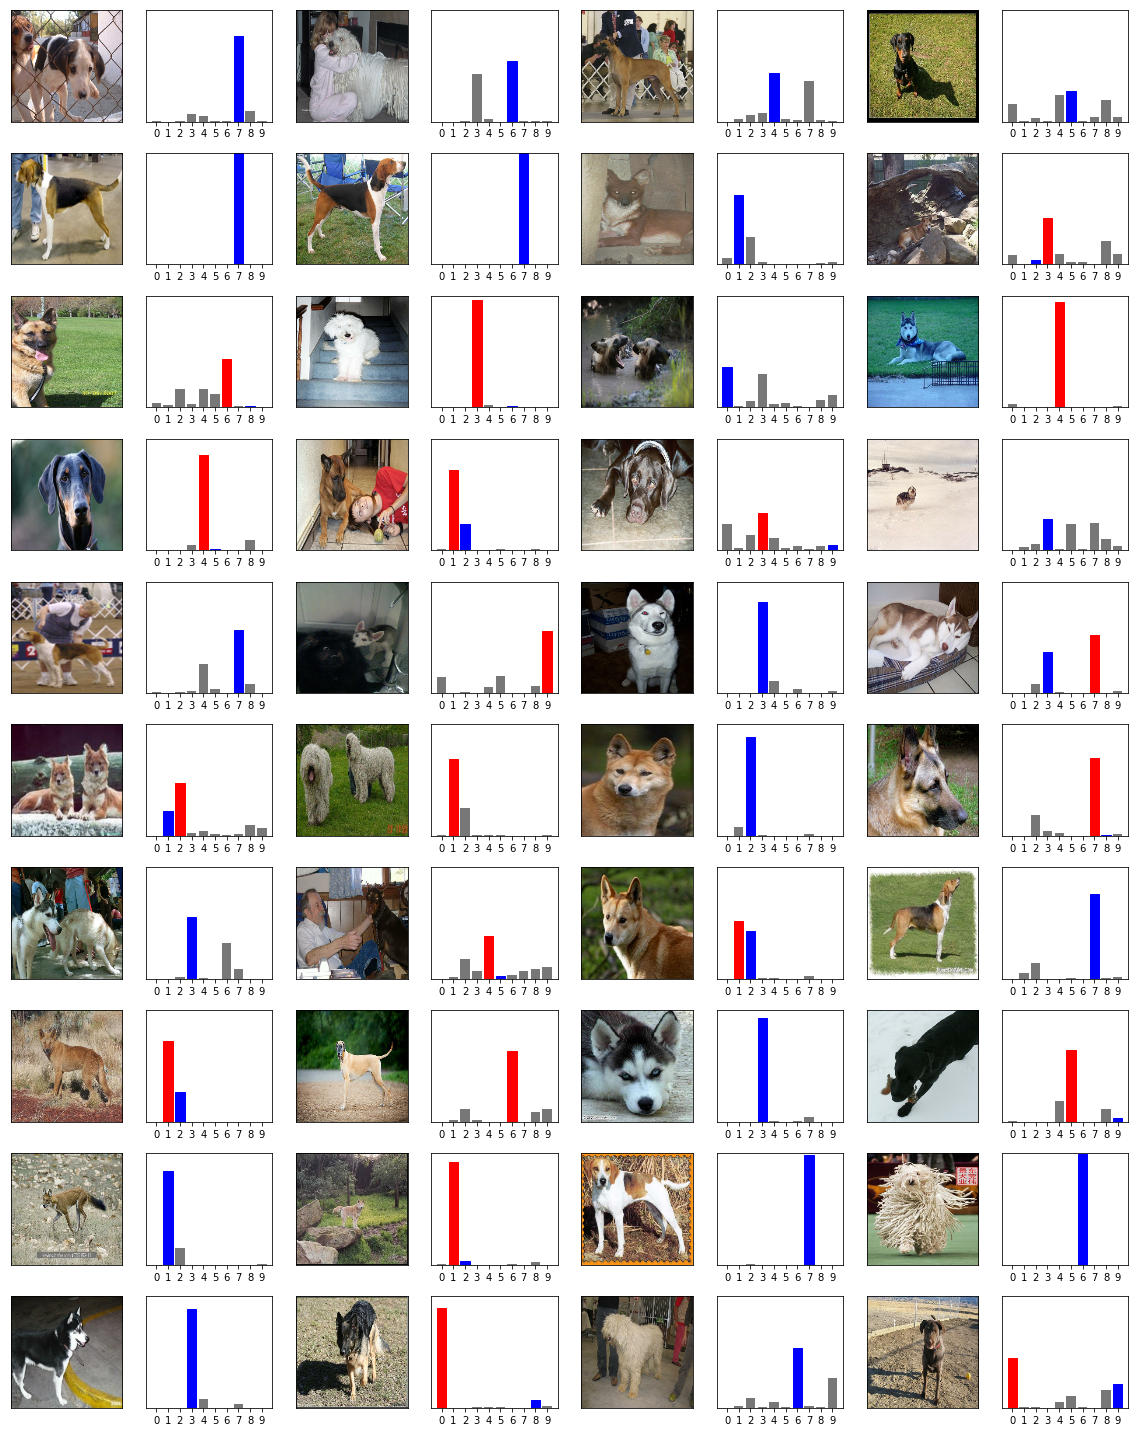

In [106]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], label_batch, image_batch + 0.5)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], label_batch.numpy())
plt.tight_layout()
plt.show()

In [ ]:
model.summary()

In [ ]:
#model.get_layer('conv2d_51').weights
model.